# *Importing CSV Files*

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)

In [56]:
csv = {}
keywords = ['algo1', 'algo2', 'algo2i', 'optsol']
for keyword in keywords:
    for vc in range(3, 5):
        csv[f'{keyword}_{vc}v'] = pd.read_csv(f'results/{vc}v{keyword}.csv')

    if keyword != 'optsol':
        for vc in range(3, 7):
            csv[f'{keyword}_{vc}v_trees'] = pd.read_csv(f'results/{vc}v{keyword}trees.csv')

In [64]:
keywords = ['algo1', 'algo2', 'algo2i', 'optsol']
for keyword in keywords:
    dimensions = []
    for vc in range(3, 5):
        dimensions.append(csv[f'{keyword}_{vc}v'].shape)
        
    for vc in range(3, 7):
        if keyword != 'optsol':
            dimensions.append(csv[f'{keyword}_{vc}v_trees'].shape)
    
    print(dimensions)

[(63, 4), (2149, 4), (12, 4), (128, 4), (2000, 4), (41472, 4)]
[(63, 4), (2149, 4), (12, 4), (128, 4), (2000, 4), (41472, 4)]
[(63, 4), (2149, 4), (12, 4), (128, 4), (2000, 4), (41472, 4)]
[(63, 4), (2149, 4)]


# *Defining Functions*

In [87]:
from classes import LinearOrder
from utils import preprocess

def countTranspositions(lo_input):
    pass

def countSwapPairs(lo_input):
    count = 0
    los = [lo.relations for lo in preprocess(lo_input)]
    for i in range(len(los)):
        lo_ref = sorted(los[i])
        for j in range(i + 1, len(los)):
            lo = sorted([(b, a) for a, b in los[j]])
            count += len(set(lo_ref).intersection(set(lo)))
    
    return count

def merge(dataframes, joins):
    main = pd.merge(dataframes[0], dataframes[1], how=joins[0])
    for i in range(2, len(dataframes)):
        main = pd.merge(main, dataframes[i], how=joins[i - 1])
    
    return main

def extend(dataframe, keywords=['algo1', 'algo2', 'algo2i', 'optsol'], flag='all'):
    dataframe['input_size'] = dataframe['input'].map(lambda x: x.count('-') + 1)
    dataframe['vertex_count'] = dataframe['input'].map(lambda x: x.split('-')[0].count(',') + 1)
    dataframe['num_swap_pair'] = dataframe['input'].map(lambda x: countSwapPairs(x))
    # dataframe[f'num_trans_{keyword}']
    
    for keyword in keywords:
        dataframe[f'num_rel_{keyword}'] = dataframe[f'output_{keyword}'].map(lambda x: str(x).count('('))
        if keyword != 'optsol' and flag == 'all':
            dataframe[f'approx_{keyword}'] = dataframe.apply(lambda x: 
                                                             x[f'cost_{keyword}']/x[f'cost_optsol'], axis=1)
            dataframe[f'cost_diff_{keyword}'] = dataframe.apply(lambda x: 
                                                                abs(x[f'cost_{keyword}'] - x[f'cost_optsol']), axis=1)

In [6]:
def getApproxVsVal(dataframe, algorithm, columns, operator='eq', flag='all'):
    if flag == 'all':
        column = f'cost_diff_{algorithm}'
        val = 0
    else:
        column = f'cost_{algorithm}'
        val = 1
    
    if operator == 'eq':
        approx = dataframe[dataframe[column] == val]
    elif operator == 'neq':
        approx = dataframe[dataframe[column] != val]
    elif operator == 'gt':
        approx = dataframe[dataframe[column] > val]
    elif operator == 'lt':
        approx = dataframe[dataframe[column] < val]
    approx = approx[columns]
    
    return approx

def getApproxVsApprox(dataframe, algorithm1, algorithm2, columns, operator='eq'):
    column1 = f'cost_{algorithm1}'
    column2 = f'cost_{algorithm2}'
    if operator == 'eq':
        approx = dataframe[dataframe[column1] == dataframe[column2]]
    if operator == 'neq':
        approx = dataframe[dataframe[column1] != dataframe[column2]]
    if operator == 'gt':
        approx = dataframe[dataframe[column1] > dataframe[column2]]
    if operator == 'lt':
        approx = dataframe[dataframe[column1] < dataframe[column2]]
    approx = approx[columns]
    
    return approx

In [ ]:
def plotScatter(dataframe, columns):
    analysis = dataframe[columns]
    ax = sns.regplot(x=columns[0], y=columns[1], data=analysis)
    slope, intercept, r_value, p_value, std_err = sc.stats.linregress(x=ax.get_lines()[0].get_xdata(),
                                                                      y=ax.get_lines()[0].get_ydata())
    
    print(f"y = {slope:.5f}x + {intercept:.5f}")
    plt.show()

# *Analysis according to Vertex Count*

In [68]:
results_vc = {}
joins_all = ['inner', 'inner', 'inner']
keywords = ['algo1', 'algo2', 'algo2i', 'optsol']
for vc in range(3, 5):
    results_vc[f'all{vc}'] = merge([csv[f'{keyword}_{vc}v'] for keyword in keywords], joins_all)

results_vc['allv'] = merge([results_vc['all3'], results_vc['all4']], ['outer'])
results_vc['optsol'] = merge([csv[f'optsol_{vc}v'] for vc in range(3, 5)], ['outer'])
                            
joins_algo = ['outer', 'inner']
for keyword in keywords:
    results_vc[f'{keyword}'] = merge([csv[f'{keyword}_{vc}v'] for vc in range(3, 5)] + [results_vc['optsol']], 
                                     joins_algo)

In [71]:
for key in results_vc.keys():
    if 'all' in key:
        extend(results_vc[key])
    elif 'optsol' in key:
        extend(results_vc[key], ['optsol'])
    elif 'algo2i' in key:
        extend(results_vc[key], ['algo2i'])
    elif 'algo1' in key:
        extend(results_vc[key], ['algo1'])
    elif 'algo2' in key:
        extend(results_vc[key], ['algo2'])

In [81]:
dimensions = []
for vc in range(3, 5):
    dimensions.append(results_vc[f'all{vc}'].shape)
dimensions.append(results_vc['allv'].shape)

print(dimensions[:4])

keywords = ['algo1', 'algo2', 'algo2i', 'optsol']
for keyword in keywords:
    dimensions.append(results_vc[f'{keyword}'].shape)
    
print(dimensions[3:])

[(63, 25), (2149, 25), (2212, 25)]
[(2212, 12), (2212, 12), (2212, 12), (2212, 7)]


y = 0.00043x + -0.00149


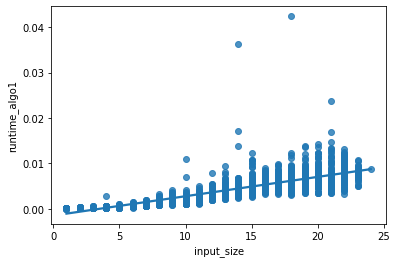

y = 0.00028x + -0.00120


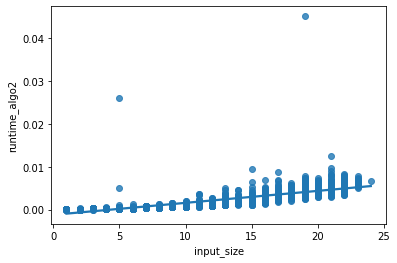

y = 0.00001x + 0.00004


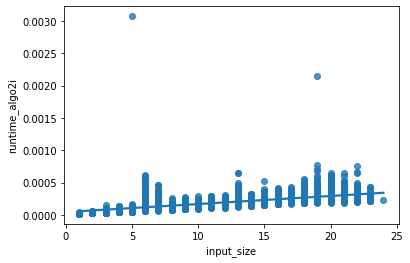

y = 81.72959x + -548.64914


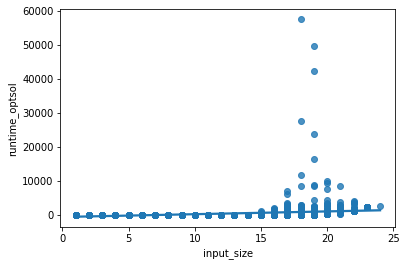

In [83]:
keywords = ['algo1', 'algo2', 'algo2i', 'optsol']
for keyword in keywords:
    plotScatter(results_vc[keyword], ['input_size', f'runtime_{keyword}'])

y = 0.23389x + 3.11878


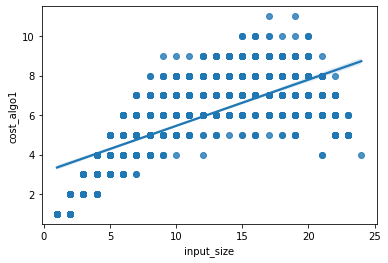

y = 1.45978x + -2.63095


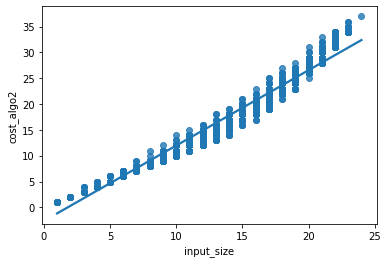

y = 0.36696x + 2.24680


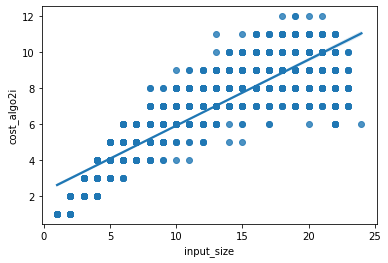

y = 0.10106x + 3.40839


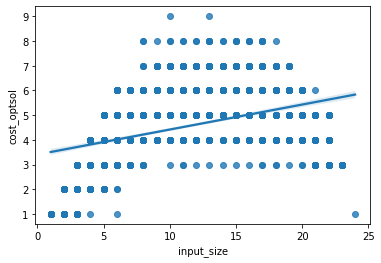

In [84]:
keywords = ['algo1', 'algo2', 'algo2i', 'optsol']
for keyword in keywords:
    plotScatter(results_vc[keyword], ['input_size', f'cost_{keyword}'])

y = 0.76879x + 9.25981


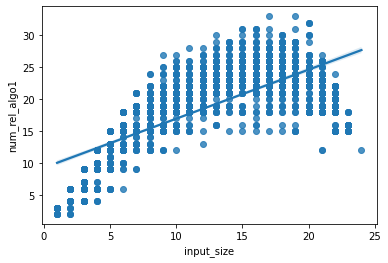

y = 6.98824x + -8.00473


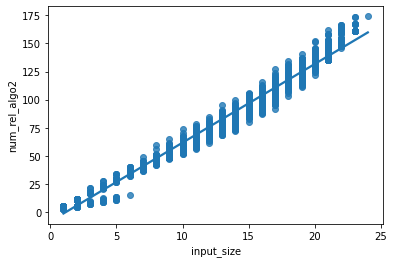

y = 1.71732x + 14.38314


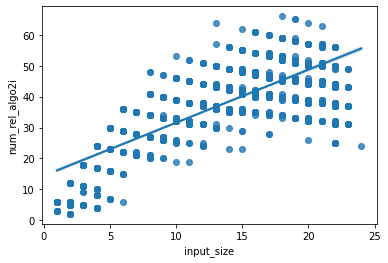

y = 0.06677x + 21.15441


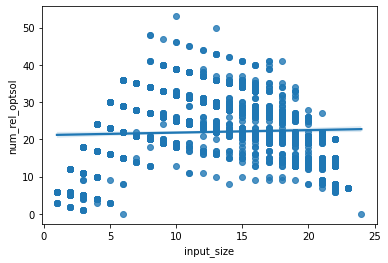

In [39]:
plotScatter(algo1, ['input_size', 'num_rel_algo1'])
plotScatter(algo2, ['input_size', 'num_rel_algo2'])
plotScatter(algo2i, ['input_size', 'num_rel_algo2i'])
plotScatter(optsol, ['input_size', 'num_rel_optsol'])

y = 0.02855x + 0.95651


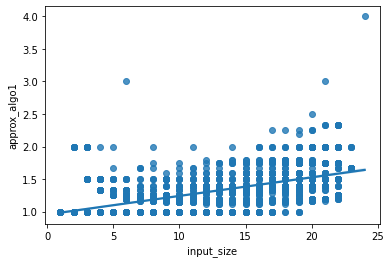

y = 0.31785x + -0.50780


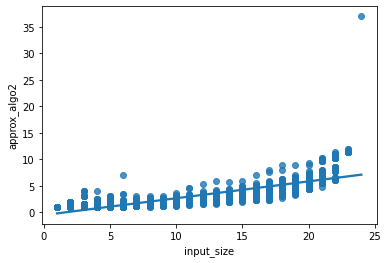

y = 0.06149x + 0.71766


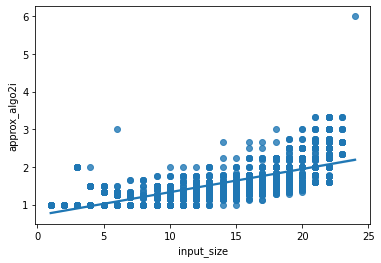

In [85]:
keywords = ['algo1', 'algo2', 'algo2i']
for keyword in keywords:
    plotScatter(results_vc[keyword], ['input_size', f'approx_{keyword}'])

y = 3.21737x + -0.58322


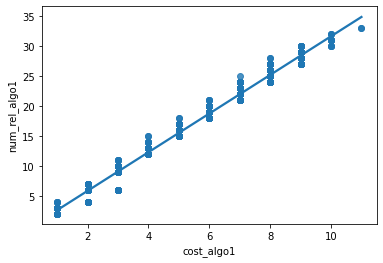

y = 4.75647x + 5.03616


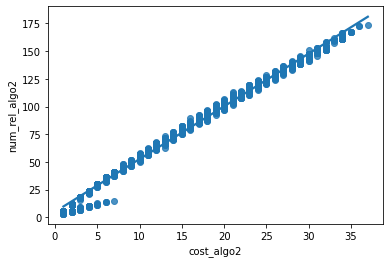

y = 5.08254x + 1.22717


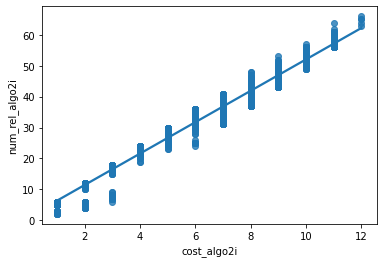

y = 5.29350x + -2.38913


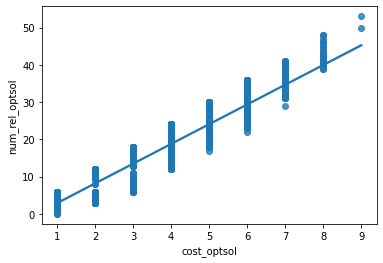

In [52]:
plotScatter(algo1, ['cost_algo1', 'num_rel_algo1'])
plotScatter(algo2, ['cost_algo2', 'num_rel_algo2'])
plotScatter(algo2i, ['cost_algo2i', 'num_rel_algo2i'])
plotScatter(optsol, ['cost_optsol', 'num_rel_optsol'])

In [40]:
columns_fixed = ['input', 'output_optsol', 'cost_optsol']
columns_algo1 = columns_fixed + ['output_algo1']
columns_algo2 = columns_fixed + ['output_algo2']
columns_algo2i = columns_fixed + ['output_algo2i']

optapprox_algo1 = getOptApprox(algo1, 'algo1', columns_algo1)
optapprox_algo2 = getOptApprox(algo2, 'algo2', columns_algo2)
optapprox_algo2i = getOptApprox(algo2i, 'algo2i', columns_algo2i)

optapprox_algo1_v3 = getOptApprox(all3, 'algo1', columns_algo1)
optapprox_algo2_v3 = getOptApprox(all3, 'algo2', columns_algo2)
optapprox_algo2i_v3 = getOptApprox(all3, 'algo2i', columns_algo2i)

optapprox_algo1_v4 = getOptApprox(all4, 'algo1', columns_algo1)
optapprox_algo2_v4 = getOptApprox(all4, 'algo2', columns_algo2)
optapprox_algo2i_v4 = getOptApprox(all4, 'algo2i', columns_algo2i)

print(optapprox_algo1.shape)
print(optapprox_algo2.shape)
print(optapprox_algo2i.shape)
print('---')
print(optapprox_algo1_v3.shape)
print(optapprox_algo2_v3.shape)
print(optapprox_algo2i_v3.shape)
print('---')
print(optapprox_algo1_v4.shape)
print(optapprox_algo2_v4.shape)
print(optapprox_algo2i_v4.shape)

(716, 4)
(264, 4)
(714, 4)
---
(29, 4)
(17, 4)
(43, 4)
---
(687, 4)
(247, 4)
(671, 4)


In [41]:
columns_fixed = ['input', 'cost_optsol']
columns_algo1 = columns_fixed + ['cost_algo1', 'approx_algo1']
columns_algo2 = columns_fixed + ['cost_algo2', 'approx_algo2']
columns_algo2i = columns_fixed + ['cost_algo2i', 'approx_algo2i']

nonoptapprox_algo1 = getNonoptApprox(algo1, 'algo1', columns_algo1)
nonoptapprox_algo2 = getNonoptApprox(algo2, 'algo2', columns_algo2)
nonoptapprox_algo2i = getNonoptApprox(algo2i, 'algo2i', columns_algo2i)

nonoptapprox_algo1_v3 = getNonoptApprox(all3, 'algo1', columns_algo1)
nonoptapprox_algo2_v3 = getNonoptApprox(all3, 'algo2', columns_algo2)
nonoptapprox_algo2i_v3 = getNonoptApprox(all3, 'algo2i', columns_algo2i)

nonoptapprox_algo1_v4 = getNonoptApprox(all4, 'algo1', columns_algo1)
nonoptapprox_algo2_v4 = getNonoptApprox(all4, 'algo2', columns_algo2)
nonoptapprox_algo2i_v4 = getNonoptApprox(all4, 'algo2i', columns_algo2i)

print(nonoptapprox_algo1.describe())
print(nonoptapprox_algo2.describe())
print(nonoptapprox_algo2i.describe())
print('---')
print(nonoptapprox_algo1_v3.describe())
print(nonoptapprox_algo2_v3.describe())
print(nonoptapprox_algo2i_v3.describe())
print('---')
print(nonoptapprox_algo1_v4.describe())
print(nonoptapprox_algo2_v4.describe())
print(nonoptapprox_algo2i_v4.describe())

       cost_optsol   cost_algo1  approx_algo1
count  1496.000000  1496.000000   1496.000000
mean      4.830214     6.709893      1.431651
std       1.284035     1.482584      0.272085
min       1.000000     2.000000      1.125000
25%       4.000000     6.000000      1.200000
50%       5.000000     7.000000      1.400000
75%       6.000000     8.000000      1.500000
max       8.000000    11.000000      4.000000
       cost_optsol   cost_algo2  approx_algo2
count  1948.000000  1948.000000   1948.000000
mean      4.828542    16.100103      3.528950
std       1.395703     8.814748      2.466345
min       1.000000     2.000000      1.111111
25%       4.000000     9.000000      1.794444
50%       5.000000    15.000000      2.666667
75%       6.000000    23.000000      4.500000
max       9.000000    37.000000     37.000000
       cost_optsol  cost_algo2i  approx_algo2i
count  1498.000000  1498.000000    1498.000000
mean      4.993992     7.892523       1.650031
std       1.266427     1.767308

In [42]:
columns_fixed = ['input']
columns_algo1_algo2 = columns_fixed + ['output_algo1', 'output_algo2']
columns_algo2_algo2i = columns_fixed + ['output_algo2', 'output_algo2i']

sameapprox_algo1_algo2_v3 = getSameApprox(all3, 'algo1', 'algo2', columns_algo1_algo2)
sameapprox_algo2_algo2i_v3 = getSameApprox(all3, 'algo2', 'algo2i', columns_algo2_algo2i)

sameapprox_algo1_algo2_v4 = getSameApprox(all4, 'algo1', 'algo2', columns_algo1_algo2)
sameapprox_algo2_algo2i_v4 = getSameApprox(all4, 'algo2', 'algo2i', columns_algo2_algo2i)

print(sameapprox_algo1_algo2_v3.shape)
print(sameapprox_algo2_algo2i_v3.shape)
print(sameapprox_algo1_algo2_v4.shape)
print(sameapprox_algo2_algo2i_v4.shape)

#optapprox_joined = pd.merge(optapprox1, optapprox2, how='outer')
#optapprox_joined

(26, 3)
(17, 3)
(313, 3)
(247, 3)


## Trees

In [44]:
all3_trees = merge([algo1_3v_trees, algo2_3v_trees, algo2i_3v_trees],
                   ['inner', 'inner'])
all4_trees = merge([algo1_4v_trees, algo2_4v_trees, algo2i_4v_trees],
                   ['inner', 'inner'])
all5_trees = merge([algo1_5v_trees, algo2_5v_trees, algo2i_5v_trees],
                   ['inner', 'inner'])
all6_trees = merge([algo1_6v_trees, algo2_6v_trees, algo2i_6v_trees],
                   ['inner', 'inner'])
all_trees = merge([all3_trees, all4_trees, all5_trees, all6_trees],
                  ['outer', 'outer', 'outer'])

algo1_trees = merge([algo1_3v_trees, algo1_4v_trees, algo1_5v_trees, algo1_6v_trees],
                    ['outer', 'outer', 'outer'])
algo2_trees = merge([algo2_3v_trees, algo2_4v_trees, algo2_5v_trees, algo2_6v_trees],
                    ['outer', 'outer', 'outer'])
algo2i_trees = merge([algo2i_3v_trees, algo2i_4v_trees, algo2i_5v_trees, algo2i_6v_trees],
                     ['outer', 'outer', 'outer'])

In [45]:
extend(all3_trees, ['algo1', 'algo2', 'algo2i'], 'trees')
extend(all4_trees, ['algo1', 'algo2', 'algo2i'], 'trees')
extend(all5_trees, ['algo1', 'algo2', 'algo2i'], 'trees')
extend(all6_trees, ['algo1', 'algo2', 'algo2i'], 'trees')
extend(all_trees, ['algo1', 'algo2', 'algo2i'], 'trees')

extend(algo1_trees, ['algo1'], 'trees')
extend(algo2_trees, ['algo2'], 'trees')
extend(algo2i_trees, ['algo2i'], 'trees')

print(all3_trees.shape)
print(all4_trees.shape)
print(all5_trees.shape)
print(all6_trees.shape)
print(all_trees.shape)
print('---')
print(algo1_trees.shape)
print(algo2_trees.shape)
print(algo2i_trees.shape)

(12, 15)
(128, 15)
(2000, 15)
(41472, 15)
(43612, 15)
---
(43612, 7)
(43612, 7)
(43612, 7)


y = 0.00090x + -0.01069


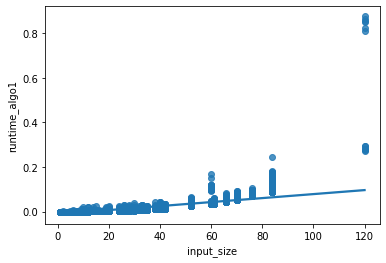

y = 0.00154x + -0.01798


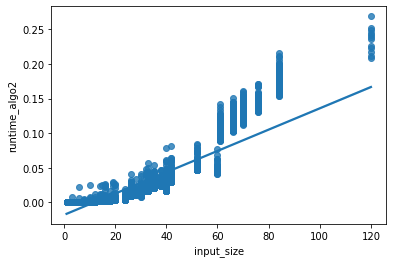

y = 0.00003x + -0.00012


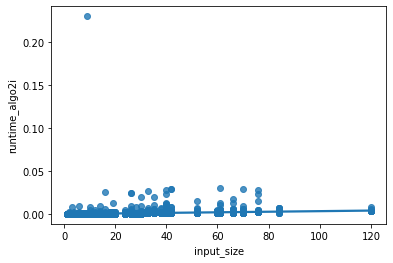

In [46]:
plotScatter(algo1_trees, ['input_size', 'runtime_algo1'])
plotScatter(algo2_trees, ['input_size', 'runtime_algo2'])
plotScatter(algo2i_trees, ['input_size', 'runtime_algo2i'])

y = 0.02191x + 1.62616


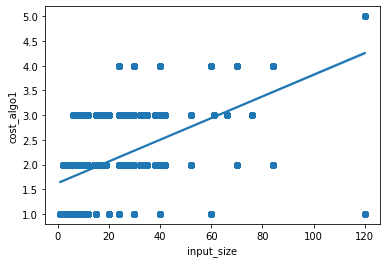

y = 2.83433x + -13.73939


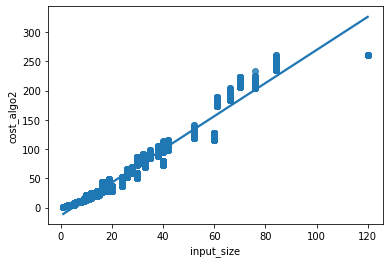

y = 0.28374x + 1.80162


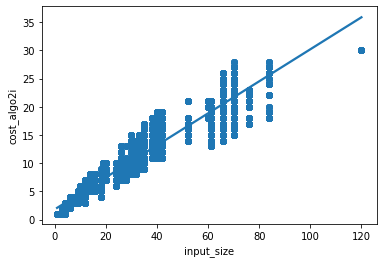

In [47]:
plotScatter(algo1_trees, ['input_size', 'cost_algo1'])
plotScatter(algo2_trees, ['input_size', 'cost_algo2'])
plotScatter(algo2i_trees, ['input_size', 'cost_algo2i'])

y = 0.15376x + 8.49239


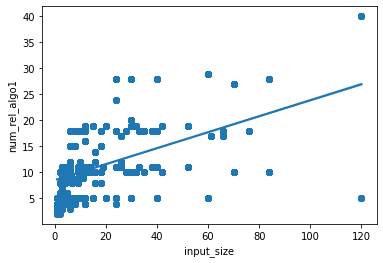

y = 36.69729x + -171.11230


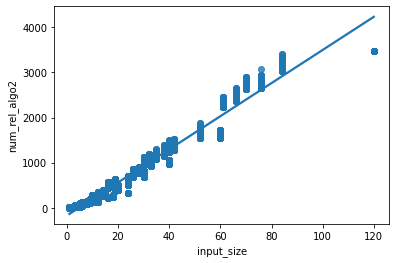

y = 3.81300x + 25.63943


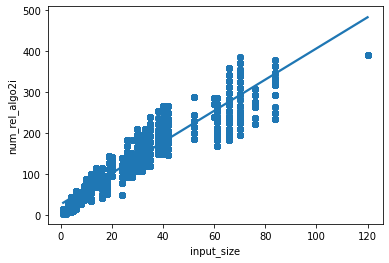

In [48]:
plotScatter(algo1_trees, ['input_size', 'num_rel_algo1'])
plotScatter(algo2_trees, ['input_size', 'num_rel_algo2'])
plotScatter(algo2i_trees, ['input_size', 'num_rel_algo2i'])

y = 0.29499x + 0.34825


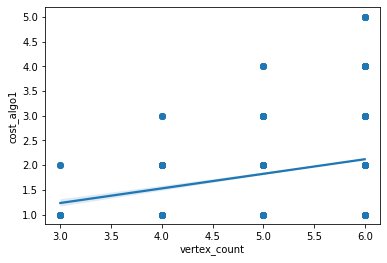

y = 35.05857x + -160.60426


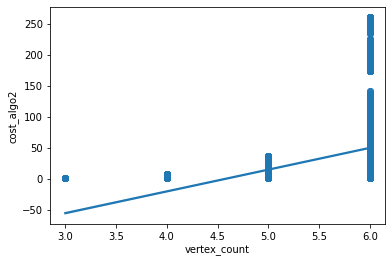

y = 4.38624x + -18.11417


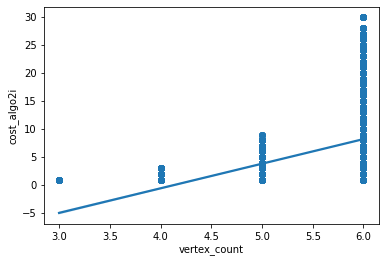

In [53]:
plotScatter(algo1_trees, ['vertex_count', 'cost_algo1'])
plotScatter(algo2_trees, ['vertex_count', 'cost_algo2'])
plotScatter(algo2i_trees, ['vertex_count', 'cost_algo2i'])

In [49]:
columns_fixed = ['input']
columns_algo1 = columns_fixed + ['output_algo1']
columns_algo2 = columns_fixed + ['output_algo2']
columns_algo2i = columns_fixed + ['output_algo2i']

optapprox_algo1_trees = getOptApprox(algo1_trees, 'algo1', columns_algo1, 'trees')
optapprox_algo2_trees = getOptApprox(algo2_trees, 'algo2', columns_algo2, 'trees')
optapprox_algo2i_trees = getOptApprox(algo2i_trees, 'algo2i', columns_algo2i, 'trees')

optapprox_algo1_v3_trees = getOptApprox(all3_trees, 'algo1', columns_algo1, 'trees')
optapprox_algo2_v3_trees = getOptApprox(all3_trees, 'algo2', columns_algo2, 'trees')
optapprox_algo2i_v3_trees = getOptApprox(all3_trees, 'algo2i', columns_algo2i, 'trees')

optapprox_algo1_v4_trees = getOptApprox(all4_trees, 'algo1', columns_algo1, 'trees')
optapprox_algo2_v4_trees = getOptApprox(all4_trees, 'algo2', columns_algo2, 'trees')
optapprox_algo2i_v4_trees = getOptApprox(all4_trees, 'algo2i', columns_algo2i, 'trees')

optapprox_algo1_v5_trees = getOptApprox(all5_trees, 'algo1', columns_algo1, 'trees')
optapprox_algo2_v5_trees = getOptApprox(all5_trees, 'algo2', columns_algo2, 'trees')
optapprox_algo2i_v5_trees = getOptApprox(all5_trees, 'algo2i', columns_algo2i, 'trees')

optapprox_algo1_v6_trees = getOptApprox(all6_trees, 'algo1', columns_algo1, 'trees')
optapprox_algo2_v6_trees = getOptApprox(all6_trees, 'algo2', columns_algo2, 'trees')
optapprox_algo2i_v6_trees = getOptApprox(all6_trees, 'algo2i', columns_algo2i, 'trees')

print(optapprox_algo1_trees.shape)
print(optapprox_algo2_trees.shape)
print(optapprox_algo2i_trees.shape)
print('---')
print(optapprox_algo1_v3_trees.shape)
print(optapprox_algo2_v3_trees.shape)
print(optapprox_algo2i_v3_trees.shape)
print('---')
print(optapprox_algo1_v4_trees.shape)
print(optapprox_algo2_v4_trees.shape)
print(optapprox_algo2i_v4_trees.shape)
print('---')
print(optapprox_algo1_v5_trees.shape)
print(optapprox_algo2_v5_trees.shape)
print(optapprox_algo2i_v5_trees.shape)
print('---')
print(optapprox_algo1_v6_trees.shape)
print(optapprox_algo2_v6_trees.shape)
print(optapprox_algo2i_v6_trees.shape)

(8474, 2)
(870, 2)
(1950, 2)
---
(9, 2)
(6, 2)
(12, 2)
---
(64, 2)
(24, 2)
(48, 2)
---
(625, 2)
(120, 2)
(270, 2)
---
(7776, 2)
(720, 2)
(1620, 2)


In [50]:
columns_fixed = ['input']
columns_algo1 = columns_fixed + ['cost_algo1']
columns_algo2 = columns_fixed + ['cost_algo2']
columns_algo2i = columns_fixed + ['cost_algo2i']

nonoptapprox_algo1_trees = getNonoptApprox(algo1_trees, 'algo1', columns_algo1, 'trees')
nonoptapprox_algo2_trees = getNonoptApprox(algo2_trees, 'algo2', columns_algo2, 'trees')
nonoptapprox_algo2i_trees = getNonoptApprox(algo2i_trees, 'algo2i', columns_algo2i, 'trees')

print(nonoptapprox_algo1_trees.describe())
print(nonoptapprox_algo2_trees.describe())
print(nonoptapprox_algo2i_trees.describe())

         cost_algo1
count  35138.000000
mean       2.368604
std        0.535711
min        2.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        5.000000
         cost_algo2
count  42742.000000
mean      48.859389
std       49.979584
min        2.000000
25%       13.000000
50%       31.000000
75%       72.000000
max      261.000000
        cost_algo2i
count  41662.000000
mean       8.299146
std        5.078989
min        2.000000
25%        4.000000
50%        7.000000
75%       12.000000
max       30.000000


In [51]:
columns_fixed = ['input']
columns_algo1_algo2 = columns_fixed + ['output_algo1', 'output_algo2']
columns_algo2_algo2i = columns_fixed + ['output_algo2', 'output_algo2i']

sameapprox_algo1_algo2_trees = getSameApprox(all_trees, 'algo1', 'algo2', columns_algo1_algo2)
sameapprox_algo2_algo2i_trees = getSameApprox(all_trees, 'algo2', 'algo2i', columns_algo2_algo2i)

print(sameapprox_algo1_algo2_trees.shape)
print(sameapprox_algo2_algo2i_trees.shape)

(1305, 3)
(870, 3)


### TO-DO

<ul>
    <li>cost and num rel?
    <li>cost diff algo1 and algo2
    <li>cost diff algo2 and algo2i
</ul>